# Clasificación de Riesgo de Asteroides (Sin MOID ni H)

Se entrena un modelo de Random Forest y una Red Neuronal excluyendo las variables MOID y H para evaluar la capacidad de predicción con información orbital limitada.


# Adquisición de Datos
Se obtienen datos de la API de la NASA SBDB. En este experimento se excluyen deliberadamente MOID y H para simular condiciones de observación temprana.

In [12]:
# IMPORTACIÓN DE LIBRERÍAS CIENTÍFICAS
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Librería para Explicabilidad (eXplainable AI)
import random

# Scikit-Learn (Modelado Estadístico)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, recall_score, fbeta_score, make_scorer
)
from sklearn.impute import SimpleImputer

# TensorFlow (Redes Neuronales)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Manejo de Desbalance
from imblearn.over_sampling import SMOTE

# Configuración de Gráficos
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12, 6)
print("Entorno inicializado.")

Entorno inicializado.


In [13]:
def get_nasa_asteroid_data(limit=50000, save_path="asteroids_data.csv"):
    """
    Módulo de Ingesta de Datos: Conexión API NASA SBDB.
    Implementa caché local para eficiencia en la investigación.
    """
    if os.path.exists(save_path):
        print(f"Cargando dataset local: {save_path}")
        return pd.read_csv(save_path)
    
    print(f"Conectando a NASA JPL (Solicitando {limit} registros)...")
    url = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"
    params = {
        "fields": "full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,moid,pha",
        "sb-group": "neo",
        "limit": limit,
        "full-prec": "true"
    }

    try:
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data['data'], columns=data['fields'])
        df.to_csv(save_path, index=False)
        print(f"Dataset generado: {len(df)} registros.")
        return df

    except Exception as err:
        print(f"ERROR Fallo en conexión API: {err}")
        return None

df_raw = get_nasa_asteroid_data()

# --- VISTA PREVIA DEL DATASET ---
print("\n MUESTRA DE DATOS:")
pd.set_option('display.max_columns', None)
display(df_raw.head())

Cargando dataset local: asteroids_data.csv

 MUESTRA DE DATOS:


,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,moid,pha
0,433 Eros (A898 PA),1.458121,0.222836,10.828467,304.270103,178.929754,1.133199,1.783043,1.760753,46582.0,0.0,9130,10.38,0.148353,N
1,719 Albert (A911 TB),2.636590,0.546596,11.573111,183.860972,156.189404,1.195441,4.077740,4.281266,41449.0,0.0,2111,15.59,0.201318,N
2,887 Alinda (A918 AA),2.473629,0.571170,9.400060,110.405876,350.534501,1.060766,3.886491,3.890541,39281.0,0.0,5880,13.81,0.079677,N
3,1036 Ganymed (A924 UB),2.664969,0.533213,26.680736,215.441191,132.503117,1.243972,4.085966,4.350572,36982.0,0.0,12915,9.18,0.343339,N
4,1221 Amor (1932 EA1),1.919831,0.434632,11.868823,171.237188,26.758225,1.085411,2.754252,2.660130,33947.0,0.0,686,17.37,0.107969,N


## Preprocesamiento y Análisis Exploratorio (EDA)


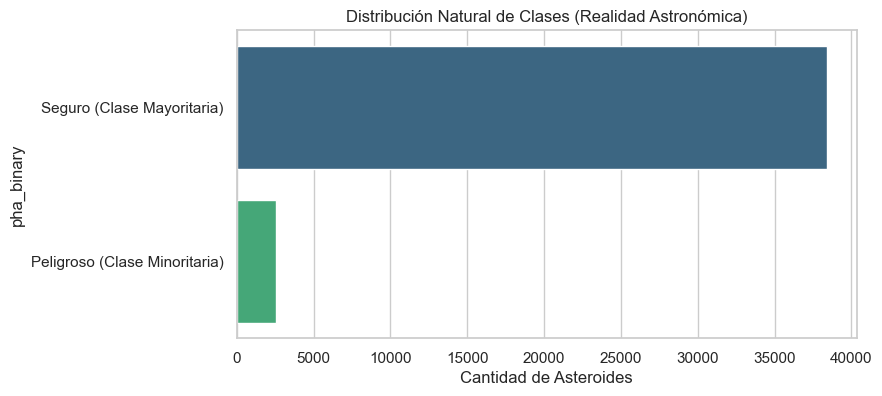

Desbalance: 93.81% Seguros vs 6.19% Peligrosos


In [14]:
def preprocess_data(df):
    df_clean = df.copy()
    
    # Conversión de tipos
    cols_numeric = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'n_obs_used', 'condition_code']
    for col in cols_numeric:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Target Encoding
    df_clean['pha_binary'] = df_clean['pha'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

    # Filtrado de Calidad
    df_clean = df_clean.dropna(subset=['a', 'e', 'i'])

    # Imputación Estadística
    imputer = SimpleImputer(strategy='median')
    if cols_numeric:
        df_clean[cols_numeric] = imputer.fit_transform(df_clean[cols_numeric])

    return df_clean

df_proc = preprocess_data(df_raw)

# Visualización del Desbalance
plt.figure(figsize=(8, 4))
sns.countplot(y='pha_binary', data=df_proc, palette='viridis')
plt.title('Distribución Natural de Clases (Realidad Astronómica)')
plt.yticks([0, 1], ['Seguro (Clase Mayoritaria)', 'Peligroso (Clase Minoritaria)'])
plt.xlabel('Cantidad de Asteroides')
plt.show()

ratio = df_proc['pha_binary'].value_counts(normalize=True)
print(f"Desbalance: {ratio[0]*100:.2f}% Seguros vs {ratio[1]*100:.2f}% Peligrosos")

## Balanceo Sintético (SMOTE)


In [15]:
# Selección de Características (Feature Selection)
features = ['a', 'e', 'i', 'om', 'w', 'q', 'condition_code', 'n_obs_used']
X = df_proc[features]
y = df_proc['pha_binary']

# División Estratificada (80% Entrenamiento / 20% Validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado de Variables (Normalización Z-Score)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicación de SMOTE (Solo en Entrenamiento)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Muestras originales: {len(y_train)}")
print(f"Muestras tras SMOTE: {len(y_train_res)} (Balanceado 50/50)")

Muestras originales: 32761
Muestras tras SMOTE: 61470 (Balanceado 50/50)


## Modelo Computacional

In [16]:
# --- RANDOM FOREST ---
print("Entrenando Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train_res, y_train_res)

# --- RED NEURONAL PROFUNDA ---
print("Entrenando Red Neuronal")
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks para optimización
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_nn.fit(
    X_train_res, y_train_res,
    epochs=50, batch_size=64,
    validation_split=0.2, callbacks=[early_stop], verbose=0
)
print("Entrenamiento de modelos finalizado.")

Entrenando Random Forest
Entrenando Red Neuronal
Entrenamiento de modelos finalizado.


### Diagnóstico de Entrenamiento (Red Neuronal)


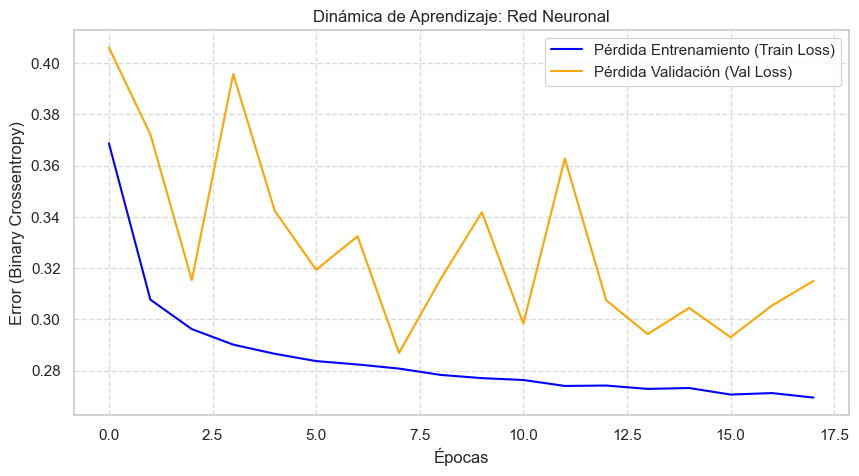

In [17]:
if 'history' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento (Train Loss)', color='blue')
    plt.plot(history.history['val_loss'], label='Pérdida Validación (Val Loss)', color='orange')
    plt.title('Dinámica de Aprendizaje: Red Neuronal')
    plt.ylabel('Error (Binary Crossentropy)')
    plt.xlabel('Épocas')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("La variable 'history' no está disponible.")

### Diagnóstico de Entrenamiento (Random Forest)


Generando curva de aprendizaje para Random Forest


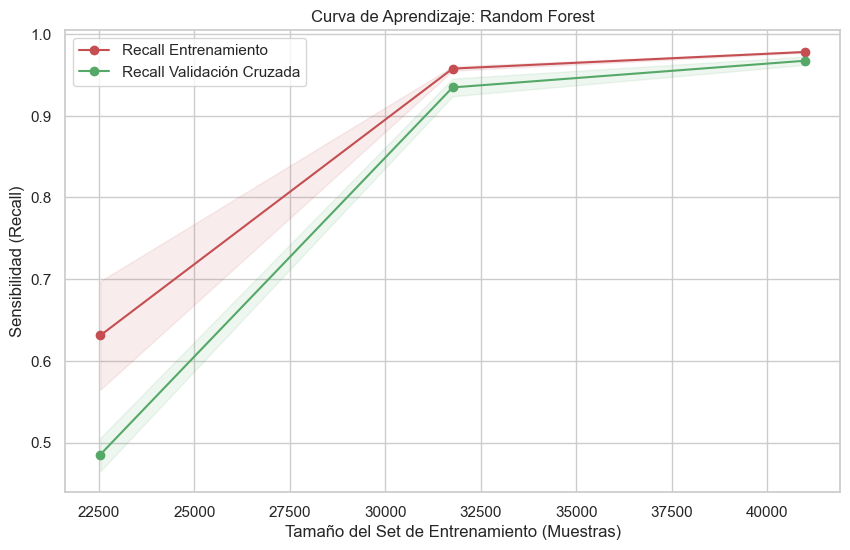

In [18]:
print("Generando curva de aprendizaje para Random Forest")
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model, 
    X=X_train_res, 
    y=y_train_res, 
    train_sizes=np.linspace(0.1, 1.0, 5), # Evaluar al 10%, 32%, 55%, 77% y 100% de datos
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# Calcular promedios y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Recall Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Recall Validación Cruzada")

# Áreas de incertidumbre
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.title("Curva de Aprendizaje: Random Forest")
plt.xlabel("Tamaño del Set de Entrenamiento (Muestras)")
plt.ylabel("Sensibilidad (Recall)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

### Matrices de Confusión
.

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


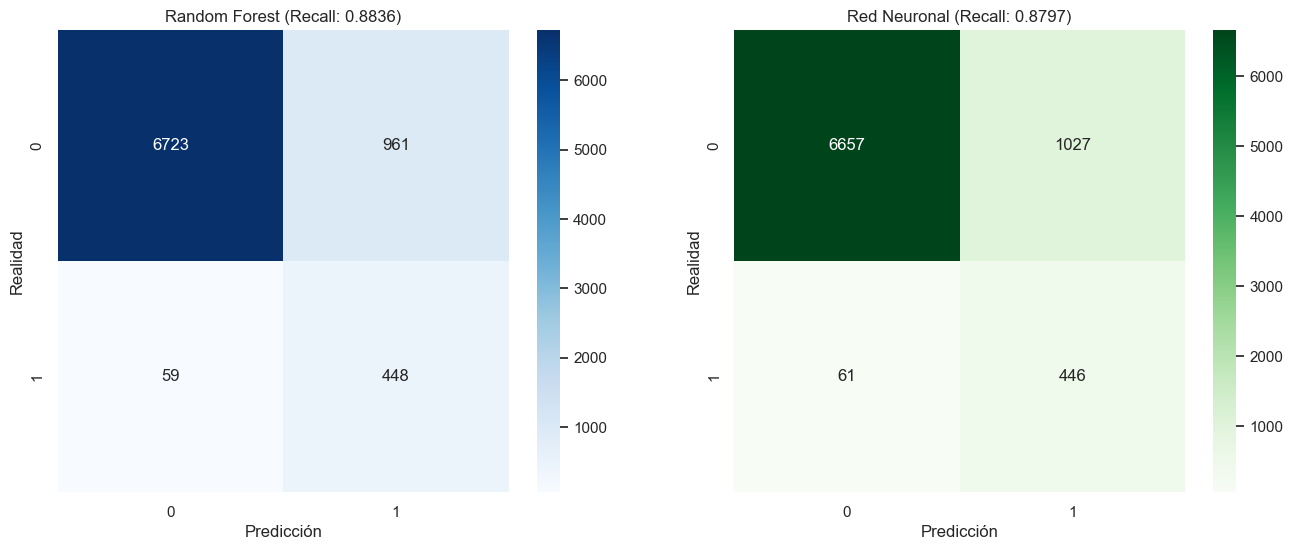


=== REPORTE RANDOM FOREST ===
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7684
           1       0.32      0.88      0.47       507

    accuracy                           0.88      8191
   macro avg       0.65      0.88      0.70      8191
weighted avg       0.95      0.88      0.90      8191


=== REPORTE RED NEURONAL ===
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      7684
           1       0.30      0.88      0.45       507

    accuracy                           0.87      8191
   macro avg       0.65      0.87      0.69      8191
weighted avg       0.95      0.87      0.90      8191



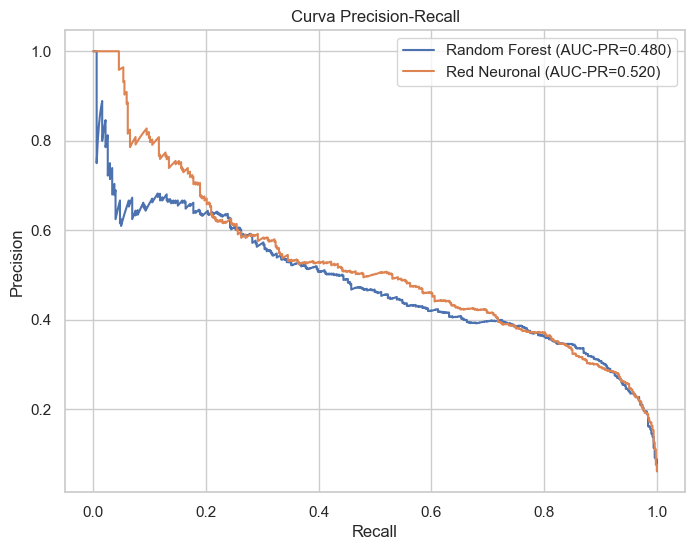


AUC-PR:
Random Forest: 0.4803
Red Neuronal: 0.5197


In [19]:
# Generación de Métricas
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

y_prob_nn = model_nn.predict(X_test_scaled).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Visualización de Matrices de Confusión
def plot_comparison(y_test, pred_rf, pred_nn):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title(f'Random Forest (Recall: {recall_score(y_test, pred_rf):.4f})')
    ax[0].set_xlabel('Predicción'); ax[0].set_ylabel('Realidad')
    
    sns.heatmap(confusion_matrix(y_test, pred_nn), annot=True, fmt='d', cmap='Greens', ax=ax[1])
    ax[1].set_title(f'Red Neuronal (Recall: {recall_score(y_test, pred_nn):.4f})')
    ax[1].set_xlabel('Predicción'); ax[1].set_ylabel('Realidad')
    plt.show()

plot_comparison(y_test, y_pred_rf, y_pred_nn)

# Tabla de Métricas Detallada
print("\n=== REPORTE RANDOM FOREST ===")
print(classification_report(y_test, y_pred_rf))
print("\n=== REPORTE RED NEURONAL ===")
print(classification_report(y_test, y_pred_nn))

# Curva Precision-Recall y AUC-PR
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc_rf = auc(recall_rf, precision_rf)
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_prob_nn)
pr_auc_nn = auc(recall_nn, precision_nn)

plt.figure(figsize=(8,6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC-PR={pr_auc_rf:.3f})')
plt.plot(recall_nn, precision_nn, label=f'Red Neuronal (AUC-PR={pr_auc_nn:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

print('\nAUC-PR:')
print(f'Random Forest: {pr_auc_rf:.4f}')
print(f'Red Neuronal: {pr_auc_nn:.4f}')

### F2-Score y Validación Cruzada


In [20]:
# Definir F2-Score como métrica
f2_scorer = make_scorer(fbeta_score, beta=2)

print("Ejecutando Validación Cruzada (5-Folds) para Random Forest")
# Usamos StratifiedKFold para mantener el balance de clases en cada fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=cv, scoring=f2_scorer, n_jobs=-1)

print(f"\n Resultados de Validación Cruzada (F2-Score):")
print(f"Scores por Fold: {cv_scores}")
print(f"Media F2-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Ejecutando Validación Cruzada (5-Folds) para Random Forest

 Resultados de Validación Cruzada (F2-Score):
Scores por Fold: [0.94949883 0.95445412 0.95111736 0.95284558 0.95106349]
Media F2-Score: 0.9518 (+/- 0.0034)


### Análisis de Explicabilidad Comparativa (SHAP Values)


Generando SHAP...


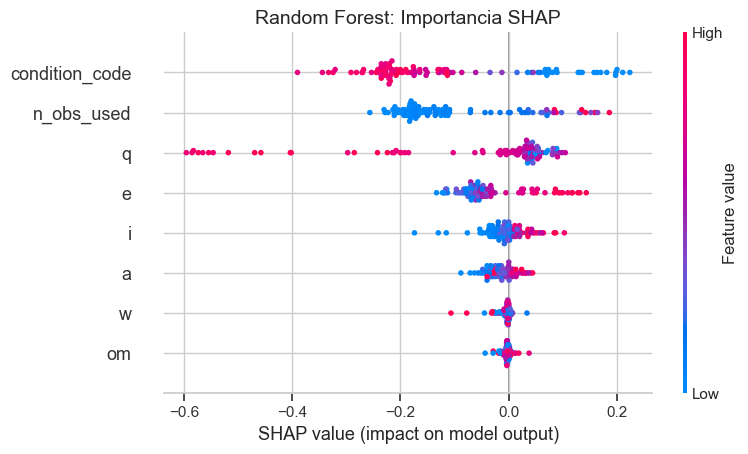

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 4

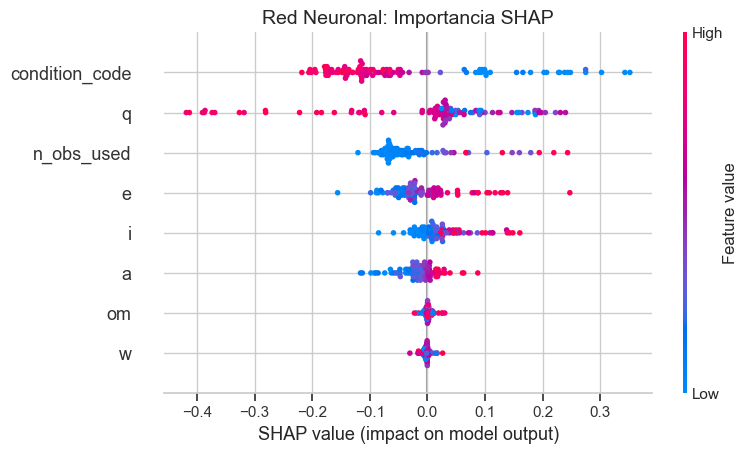

Completado


In [21]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('shap').setLevel(logging.ERROR)

print("Generando SHAP...") 

# RANDOM FOREST
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_scaled[:100], check_additivity=False)

if isinstance(shap_values_rf, list):
    shap_data_rf = shap_values_rf[1]
elif len(shap_values_rf.shape) == 3:
    shap_data_rf = shap_values_rf[:, :, 1]
else:
    shap_data_rf = shap_values_rf

plt.figure(figsize=(10,6))
shap.summary_plot(shap_data_rf, X_test_scaled[:100], feature_names=features, show=False)
plt.title('Random Forest: Importancia SHAP', fontsize=14)
plt.tight_layout()
plt.show()

# RED NEURONAL
background = shap.sample(X_train_scaled, 50, random_state=42)
explainer_nn = shap.KernelExplainer(model_nn.predict, background)
shap_values_nn = explainer_nn.shap_values(X_test_scaled[:100], silent=True)

if isinstance(shap_values_nn, list):
    shap_data_nn = shap_values_nn[0]
else:
    shap_data_nn = shap_values_nn
    
if len(shap_data_nn.shape) == 3:
    shap_data_nn = shap_data_nn[:, :, 0]

plt.figure(figsize=(10,6))
shap.summary_plot(shap_data_nn, X_test_scaled[:100], feature_names=features, show=False)
plt.title('Red Neuronal: Importancia SHAP', fontsize=14)
plt.tight_layout()
plt.show()

print("Completado")

## Simulación Operativa

In [22]:
def run_simulation():
    print("\n--- EVALUACIÓN FINAL: COMPARATIVA DE MODELOS Y PROPIEDADES FÍSICAS ---")
    print("Objetivo: Validación integral con datos físicos y confianza por modelo.\n")
    
    # 1. Muestreo Estratificado
    dang_indices = y_test[y_test == 1].index.tolist()
    safe_indices = y_test[y_test == 0].index.tolist()
    
    sample_dang = random.sample(dang_indices, 5)
    sample_safe = random.sample(safe_indices, 5)
    simulation_indices = sample_dang + sample_safe
    random.shuffle(simulation_indices)
    
    results = []
    
    for idx in simulation_indices:
        # Recuperar datos de entrada (features)
        obj_data = X_test.loc[idx].values.reshape(1, -1)
        obj_data_scaled = scaler.transform(obj_data)
        
        # --- RECUPERACIÓN DE METADATA (Nombre) ---
        real_name = "Unknown"
        try:
            row_raw = df_raw.loc[idx]
            real_name = row_raw['full_name']
        except:
            try: real_name = df_proc.loc[idx]['full_name']
            except: real_name = f"ID_{idx}"
        
        # Predicciones
        p_rf = rf_model.predict_proba(obj_data_scaled)[0][1]
        p_nn = model_nn.predict(obj_data_scaled, verbose=0).flatten()[0]
        
        results.append({
            'Objeto': real_name,
            'Realidad': 'PELIGRO' if y_test.loc[idx] == 1 else 'Seguro',
            'RF Pred': 'PELIGRO' if p_rf > 0.5 else 'Seguro',
            'RF Conf': f"{p_rf*100:.1f}%",
            'NN Pred': 'PELIGRO' if p_nn > 0.5 else 'Seguro',
            'NN Conf': f"{p_nn*100:.1f}%"
        })

    res_df = pd.DataFrame(results)
    
    def style_table(styler):
        styler.applymap(lambda v: 'color: red; font-weight: bold' if v == 'PELIGRO' else 'color: green', subset=['Realidad'])
        styler.applymap(lambda v: 'background-color: #ffcccc' if v == 'PELIGRO' else 'background-color: #ccffcc', subset=['RF Pred', 'NN Pred'])
        return styler
    
    try:
        display(style_table(res_df.style))
    except:
        display(res_df)

run_simulation()


--- EVALUACIÓN FINAL: COMPARATIVA DE MODELOS Y PROPIEDADES FÍSICAS ---
Objetivo: Validación integral con datos físicos y confianza por modelo.



,Objeto,Realidad,RF Pred,RF Conf,NN Pred,NN Conf
0,(2025 XR4),Seguro,PELIGRO,50.9%,Seguro,31.9%
1,(2024 YH9),Seguro,Seguro,0.6%,Seguro,0.0%
2,(2007 HA),PELIGRO,PELIGRO,84.7%,PELIGRO,77.4%
3,(2010 JJ41),PELIGRO,Seguro,8.0%,Seguro,3.5%
4,(2022 SS37),Seguro,Seguro,1.6%,Seguro,2.4%
5,(2022 GF5),Seguro,Seguro,3.5%,Seguro,0.0%
6,(2025 MJ90),PELIGRO,PELIGRO,73.8%,PELIGRO,86.0%
7,(2023 HY5),Seguro,Seguro,12.8%,Seguro,16.6%
8,476601 (2008 SE85),PELIGRO,PELIGRO,87.2%,PELIGRO,75.2%
9,(2021 VG19),PELIGRO,PELIGRO,79.0%,PELIGRO,77.9%
